In [1]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from torch import tensor
import numpy as np
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
import random
import os
import matplotlib.pyplot as plt
#from numba import jit
import pickle
from scipy.interpolate import interp1d
from torch.utils.data import DataLoader, random_split
import torch
from torchsummary import summary
import seaborn as sns
import sys
import torch.nn.functional as F
# Req for package
sys.path.append("../")
from SkinLearning.NN.Helpers import train, test, DEVICE, getParameterLoss, setSeed
from SkinLearning.NN.Models import MultiTemporal
from SkinLearning.Utils.Dataset import getDataset, getSplit
from SkinLearning.Utils.Plotting import plotParameterBars

torch.backends.cudnn.benchmark = True

In [2]:
setSeed()


In [3]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.rnn = nn.RNN(15, 256, batch_first=True)
        self.fc1 = nn.Linear(131072, 1024)
        self.d1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(1024 , 512)
        self.d2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(512, 128)
        self.d3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(128, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        h0 = torch.zeros(1, batch_size, 256).to(x.device)
        x, _ = self.rnn(x, h0)
        x = x.reshape(batch_size, -1)
        x = self.d1(torch.relu(self.fc1(x)))
        
        x = self.d2(torch.relu(self.fc2(x)))
        
        x = self.d3(torch.relu(self.fc3(x)))
        x = self.fc4(x)
        
        x = x.view(batch_size, 6)
        return x

In [4]:
# Up samples to 256 from 128
class BestUp(nn.Module):
    def __init__(self):
        super(BestUp, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        self.d1 = nn.Dropout(0.2)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        self.d2 = nn.Dropout(0.2)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        self.d3 = nn.Dropout(0.2)
        
        
        self.rnn = nn.RNN(15, 256, batch_first=True)
        
        self.fc1 = nn.Linear(131072, 1024)
        self.d4 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(1024, 512)
        self.d5 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(512, 128)
        self.d6 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(128, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.d1(self.conv1(x)))))
        x = self.pool2(torch.relu(self.bn2(self.d2(self.conv2(x)))))
        x = self.pool3(torch.relu(self.d3(self.bn3(self.conv3(x)))))
        
        h0 = torch.zeros(1, batch_size, 256).to(x.device)
        x, _ = self.rnn(x, h0)
        x = x.reshape(batch_size, -1)
        
        x = x.view(batch_size, -1)
        
        x = torch.relu(self.fc1(x))
        x = self.d4(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d5(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d6(x)
        
        
        x = self.fc4(x)
        return x

In [5]:
# Up samples to 256 from 128
class BestUpPlus(nn.Module):
    def __init__(self):
        super(BestUpPlus, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        self.d1 = nn.Dropout(0.2)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        self.d2 = nn.Dropout(0.2)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        self.d3 = nn.Dropout(0.2)
        
        self.conv4 = nn.Conv1d(512, 1024, kernel_size=3, padding=1, bias=False)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm1d(1024)
        self.d4 = nn.Dropout(0.2)
        
        
        self.rnn = nn.RNN(7, 256, batch_first=True)
        
        self.fc1 = nn.Linear(262144, 1024)
        self.d4 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(1024, 512)
        self.d5 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(512, 128)
        self.d6 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(128, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.d1(self.conv1(x)))))
        x = self.pool2(torch.relu(self.bn2(self.d2(self.conv2(x)))))
        x = self.pool3(torch.relu(self.d3(self.bn3(self.conv3(x)))))
        x = self.pool4(torch.relu(self.d4(self.bn4(self.conv4(x)))))
        
        h0 = torch.zeros(1, batch_size, 256).to(x.device)
        x, _ = self.rnn(x, h0)
        x = x.reshape(batch_size, -1)
        
        x = x.view(batch_size, -1)
        
        x = torch.relu(self.fc1(x))
        x = self.d4(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d5(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d6(x)
        
        
        x = self.fc4(x)
        return x

In [6]:
# Up samples to 256 from 128
class BestUp2(nn.Module):
    def __init__(self):
        super(BestUp2, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        self.d1 = nn.Dropout(0.2)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        self.d2 = nn.Dropout(0.2)
        
        
        self.rnn = nn.RNN(30, 64, batch_first=True)
        
        self.fc1 = nn.Linear(32768, 1024)
        self.d4 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(1024, 512)
        self.d5 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(512, 128)
        self.d6 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(128, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.d1(self.conv1(x)))))
        x = self.pool2(torch.relu(self.bn2(self.d2(self.conv2(x)))))
        
        h0 = torch.zeros(1, batch_size, 128).to(x.device)
        x, _ = self.rnn(x, h0)
        x = x.reshape(batch_size, -1)
        
        x = x.view(batch_size, -1)
        
        x = torch.relu(self.fc1(x))
        x = self.d4(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d5(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d6(x)
        
        
        x = self.fc4(x)
        return x

In [7]:
# Remove one FC LAyer
class RNNMinus(nn.Module):
    def __init__(self):
        super(RNNMinus, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.rnn = nn.RNN(15, 256, batch_first=True)
        self.fc1 = nn.Linear(131072, 1024)
        self.d1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(1024 , 512)
        self.d2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(512, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        h0 = torch.zeros(1, batch_size, 256).to(x.device)
        x, _ = self.rnn(x, h0)
        x = x.reshape(batch_size, -1)
        x = self.d1(torch.relu(self.fc1(x)))
        
        x = self.d2(torch.relu(self.fc2(x)))
        
        x = self.fc3(x)
        
        x = x.view(batch_size, 6)
        return x

In [8]:
# Dropout before activation
class RNNMinusP(nn.Module):
    def __init__(self):
        super(RNNMinusP, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.rnn = nn.RNN(15, 256, batch_first=True)
        self.fc1 = nn.Linear(131072, 1024)
        self.d1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(1024 , 512)
        self.d2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(512, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        h0 = torch.zeros(1, batch_size, 256).to(x.device)
        x, _ = self.rnn(x, h0)
        x = x.reshape(batch_size, -1)
        x = torch.relu(self.d1(self.fc1(x)))
        
        x = torch.relu(self.d2(self.fc2(x)))
        
        x = self.fc3(x)
        
        x = x.view(batch_size, 6)
        return x

In [9]:
# Remove one FC LAyer
class RNNPlus(nn.Module):
    def __init__(self):
        super(RNNPlus, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.rnn = nn.RNN(15, 256, batch_first=True)
        self.fc1 = nn.Linear(131072, 1024)
        self.d1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(1024 , 512)
        self.d2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(512, 128)
        self.d3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(128, 64)
        self.d4 = nn.Dropout(0.5)
        
        self.fc5 = nn.Linear(64, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        h0 = torch.zeros(1, batch_size, 256).to(x.device)
        x, _ = self.rnn(x, h0)
        x = x.reshape(batch_size, -1)
        x = self.d1(torch.relu(self.fc1(x)))
        
        x = self.d2(torch.relu(self.fc2(x)))
        
        x = self.d3(torch.relu(self.fc3(x)))
        x = self.d4(torch.relu(self.fc4(x)))
        x = self.fc5(x)
        
        x = x.view(batch_size, 6)
        return x

In [10]:
dataset, scaler = getDataset()

100%|██████████████████████████████████████████████████████████████████████████████| 2241/2241 [00:36<00:00, 62.10it/s]


In [11]:
train_loader, test_loader = getSplit(dataset)

In [12]:
up = BestUp()

In [13]:
upPlus = BestUpPlus()

In [14]:
train(train_loader, up, val_loader=test_loader, LR=0.0001, epochs=700, early_stopping=True)

Using: cuda:0


100%|███████████████████████████| 56/56 [00:02<00:00, 20.11batch/s, counter=3, epoch=67, lastLoss=0.119, valLoss=0.172]


100%|██████████████████████████| 56/56 [00:02<00:00, 19.75batch/s, counter=0, epoch=135, lastLoss=0.107, valLoss=0.144]


100%|█████████████████████████| 56/56 [00:02<00:00, 19.77batch/s, counter=0, epoch=203, lastLoss=0.0998, valLoss=0.133]


100%|████████████████████████| 56/56 [00:02<00:00, 19.77batch/s, counter=38, epoch=271, lastLoss=0.0961, valLoss=0.129]


100%|████████████████████████| 56/56 [00:02<00:00, 19.63batch/s, counter=49, epoch=282, lastLoss=0.0945, valLoss=0.131]


Early stopping after 283 epochs
Average train loss: 0.045312616182111055
Average validation loss: 0.06401268693024205


([0.25787905177899767,
  0.21138659811445645,
  0.19393894475485599,
  0.18472183043403284,
  0.17668888664671353,
  0.17327566631138325,
  0.16785023281616823,
  0.16411214561334678,
  0.16303279623389244,
  0.1606799020831074,
  0.15932046515601023,
  0.1562006433627435,
  0.1530702779335635,
  0.15176138228603772,
  0.15008551866880485,
  0.14917929843068123,
  0.14898606788899219,
  0.14517599078161375,
  0.14490078948438168,
  0.14312508050352335,
  0.14281738775649241,
  0.14143850534622157,
  0.14019270054996014,
  0.1407064622534173,
  0.13825595658272505,
  0.138304952532053,
  0.13636124453374318,
  0.13609315481569087,
  0.1344486718465175,
  0.1357074991932937,
  0.13404887023248843,
  0.1324369070519294,
  0.1314592104671257,
  0.13094854660864388,
  0.13087498622813395,
  0.13108625622200115,
  0.13042660443378346,
  0.13005280268511601,
  0.13053994798766716,
  0.12980304126228606,
  0.12968340715659515,
  0.12692946421780757,
  0.12747906826968705,
  0.12586276685552938

In [15]:
train(train_loader, upPlus, val_loader=test_loader, LR=0.0001, epochs=700, early_stopping=True)

Using: cuda:0


100%|███████████████████████████| 56/56 [00:05<00:00, 10.13batch/s, counter=3, epoch=67, lastLoss=0.121, valLoss=0.172]


100%|██████████████████████████| 56/56 [00:05<00:00, 10.09batch/s, counter=1, epoch=135, lastLoss=0.109, valLoss=0.159]


100%|████████████████████████████| 56/56 [00:21<00:00,  2.61batch/s, counter=3, epoch=203, lastLoss=0.1, valLoss=0.137]


100%|████████████████████████| 56/56 [00:17<00:00,  3.14batch/s, counter=26, epoch=271, lastLoss=0.0954, valLoss=0.132]


100%|███████████████████████████| 56/56 [00:17<00:00,  3.12batch/s, counter=4, epoch=339, lastLoss=0.09, valLoss=0.141]


100%|█████████████████████████| 56/56 [00:17<00:00,  3.19batch/s, counter=6, epoch=407, lastLoss=0.0887, valLoss=0.119]


100%|█████████████████████████| 56/56 [00:18<00:00,  3.06batch/s, counter=7, epoch=475, lastLoss=0.0857, valLoss=0.123]


100%|████████████████████████| 56/56 [00:05<00:00, 10.24batch/s, counter=49, epoch=517, lastLoss=0.0847, valLoss=0.127]


Early stopping after 518 epochs
Average train loss: 0.07532862857430794
Average validation loss: 0.1074022061196821


([0.24913317284413747,
  0.20182955504528113,
  0.19026363321713038,
  0.17896467127970286,
  0.17398666297750814,
  0.16482892792139733,
  0.1639834370996271,
  0.16364390163549355,
  0.15781969523855618,
  0.15628633967467717,
  0.1544017240937267,
  0.15560100653341838,
  0.15003408065864018,
  0.14866983677659715,
  0.1486532717411007,
  0.14608245316360677,
  0.14525832807911293,
  0.14580365296985423,
  0.14538420550525188,
  0.14242187674556459,
  0.142941870726645,
  0.1403968476557306,
  0.13974426793200628,
  0.139223050459155,
  0.13812473389719213,
  0.13799357055021183,
  0.13605759385973215,
  0.1371064650427018,
  0.13494284703795398,
  0.1347267751448921,
  0.1359623188951186,
  0.13367683147745474,
  0.13221655067588603,
  0.13189618049987725,
  0.1328602603503636,
  0.13090296342436755,
  0.13034846646977322,
  0.1307860824412533,
  0.1303900315293244,
  0.1300916706344911,
  0.12991182173469237,
  0.1301267630021487,
  0.12804511881300382,
  0.1296279966565115,
  0.1

In [16]:
test(test_loader, up, scaler)

100%|██████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 94.93 batch/s]


(76.26927757263184,
 array([88.50832 , 49.398926, 99.67943 , 99.33085 , 54.342392, 66.355736],
       dtype=float32),
 0.13864405850569408)

In [17]:
test(test_loader, upPlus, scaler)

100%|██████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 61.35 batch/s]


(76.04715347290039,
 array([89.70253 , 51.85907 , 99.685936, 99.38994 , 59.374172, 56.271267],
       dtype=float32),
 0.12271963208913803)

In [30]:
class LSTMMulti(nn.Module):
    def __init__(self, input_size=128, hidden_size=512, num_layers=3, method="concatenate"):
        super(LSTMMulti, self).__init__()
        self.method = method
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        if method == 'concatenate':
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        elif method == 'multi_channel':
            self.lstm = nn.LSTM(2, hidden_size, num_layers, batch_first=True)
        elif method == 'independent':
            self.lstm = nn.LSTM(input_size//2, hidden_size, num_layers, batch_first=True)
        else:
            raise ValueError("Invalid method. Choose from 'concatenate', 'multi_channel', or 'independent'.")
        
        if method == 'independent':
            self.fc = nn.Linear(hidden_size*2, 6)
        else:
            self.fc = nn.Linear(hidden_size, 6)

    def forward(self, x):
        batch_size = x.size(0)
        signal_size = self.input_size//2

        """        signal1 = x[..., :signal_size]
        signal2 = x[..., signal_size:]
        
        x = x.reshape(batch_size, -1, self.input_size)
        signal1 = signal1.reshape(batch_size, -1, signal_size)
        signal2 = signal2.reshape(batch_size, -1, signal_size)"""

        h0 = torch.zeros((self.num_layers, batch_size, self.hidden_size)).to(x.device)  # Initialize hidden state to zeros
        c0 = torch.zeros((self.num_layers, batch_size, self.hidden_size)).to(x.device)  # Initialize cell state to zeros

        if self.method == 'concatenate':
            _, (hidden, cell) = self.lstm(x, (h0, c0))
            hidden = hidden[-1]
        elif self.method == 'multi_channel':
            output, (hidden, cell) = self.lstm(x.view(batch_size, -1, 2), (h0, c0))
            hidden = hidden[-1]
        elif self.method == 'independent':
            output1, (hidden1, cell1) = self.lstm(signal1, (h0, c0))
            output2, (hidden2, cell2) = self.lstm(signal2, (h0, c0))
            
            hidden = torch.concat((hidden1[-1], hidden2[-1]), axis=1)
            
        output = self.fc(hidden)

        return output

In [31]:
lstm = LSTMMulti()

In [32]:
train(train_loader, lstm, val_loader=test_loader, LR=0.0001, epochs=700)

Using: cuda:0


Epoch 30/700:   5%|█▊                                | 3/56 [00:00<00:00, 111.11batch/s, lastLoss=0.149, valLoss=0.149]


KeyboardInterrupt: 

In [11]:
rnn = RNN()

In [12]:
rnn_losses, rnn_val_losses, = train(train_loader, rnn, val_loader=test_loader, LR=0.0001, epochs=500)

Using: cuda:0


Epoch 102/500:  14%|████▋                            | 8/56 [00:00<00:02, 18.08batch/s, lastLoss=0.102, valLoss=0.0834]


KeyboardInterrupt: 

In [19]:
rnn_losses, rnn_val_losses, = train(train_loader, rnn, val_loader=test_loader, LR=0.0001, epochs=500)

Using: cuda:0


Epoch 136/500: 100%|███████████████████████████████| 56/56 [00:02<00:00, 21.24batch/s, lastLoss=0.0906, valLoss=0.0716]


Epoch 272/500: 100%|████████████████████████████████| 56/56 [00:02<00:00, 21.18batch/s, lastLoss=0.0802, valLoss=0.065]


Epoch 408/500: 100%|███████████████████████████████| 56/56 [00:02<00:00, 21.19batch/s, lastLoss=0.0747, valLoss=0.0539]


Epoch 500/500: 100%|████████████████████████████████| 56/56 [00:02<00:00, 21.19batch/s, lastLoss=0.0709, valLoss=0.051]


Average train loss: 0.08799270436566854
Average validation loss: 0.06974566312786191


In [16]:
bestUp = BestUp()

In [17]:
bestUp_losses, bestUp_val_losses, = train(train_loader, bestUp, val_loader=test_loader, LR=0.0001, epochs=500)

Using: cuda:0


Epoch 136/500: 100%|█████████████████████████████████| 56/56 [00:09<00:00,  5.96batch/s, lastLoss=0.106, valLoss=0.177]


Epoch 272/500: 100%|████████████████████████████████| 56/56 [00:09<00:00,  5.96batch/s, lastLoss=0.0935, valLoss=0.135]


Epoch 318/500:  12%|████▎                             | 7/56 [00:03<00:21,  2.26batch/s, lastLoss=0.092, valLoss=0.135]


RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
bestUp2 = BestUp2()

In [245]:
import gc
torch.cuda.empty_cache()
gc.collect()

4084

In [ ]:
bestUp2_losses, bestUp2_val_losses, = train(train_loader, bestUp2, val_loader=test_loader, LR=0.0001, epochs=500)

In [15]:
rnnMinus = RNNMinus()

In [ ]:
rnnMinus_losses, rnnMinus_val_losses, = train(train_loader, rnnMinus, val_loader=test_loader, LR=0.0001, epochs=500)

In [20]:
rnnMinusP = RNNMinusP()

In [21]:
rnnMinusP_losses, rnnMinusP_val_losses, = train(train_loader, rnnMinusP, val_loader=test_loader, LR=0.0001, epochs=500)

Using: cuda:0


Epoch 136/500: 100%|█████████████████████████████████| 56/56 [00:02<00:00, 20.71batch/s, lastLoss=0.0751, valLoss=0.06]


Epoch 272/500: 100%|███████████████████████████████| 56/56 [00:02<00:00, 20.73batch/s, lastLoss=0.0597, valLoss=0.0503]


Epoch 408/500: 100%|███████████████████████████████| 56/56 [00:02<00:00, 20.71batch/s, lastLoss=0.0536, valLoss=0.0462]


Epoch 500/500: 100%|███████████████████████████████| 56/56 [00:02<00:00, 20.72batch/s, lastLoss=0.0515, valLoss=0.0543]


Average train loss: 0.07019272964806962
Average validation loss: 0.06122896899891396


In [ ]:
rnnPlus = RNNPlus()

In [ ]:
rnnPlus_losses, rnnPlus_val_losses, = train(train_loader, rnnPlus, val_loader=test_loader, LR=0.0001, epochs=500)

In [ ]:
sns.set_theme()

"""
    Plots train and test curves of given models
"""
def printCurves(names, train_loss, val_loss, epochs=400, name="train_test2"):
    if len(names)%2 == 0:
        rs = len(names)//2
        cs = len(names)//2
    else:
        rs, cs = len(names), 1
        
    fig, ax = plt.subplots(
        rs, cs, figsize=(35 if len(names) != 1 else 10, len(names)*6), sharex=True, sharey=True, constrained_layout=True)
    x = range(0, epochs)
    fig.supxlabel("Epoch", fontsize=45)
    fig.supylabel("MAE", fontsize=45)

    #ax[0][1].set_xlabel("Training Loss")
    ##ax[1][1].set_xlabel("Validation Loss")
    
    tv_loss = list(zip(train_loss, val_loss))
    if cs == 1 and rs == 1:
        ax.set_title(names[0], fontsize=40)
        ax.xaxis.set_tick_params(labelsize=35)
        ax.yaxis.set_tick_params(labelsize=35)
        for j in range(2):
            ax.plot(x, tv_loss[0][j], c = "b" if j == 0 else "y", label = "Train loss" if j == 0 else "Validation loss")
    elif cs == 1:
        for i in range(len(names)):
            ax[i].set_title(names[i], fontsize=40)
            ax[i].xaxis.set_tick_params(labelsize=35)
            ax[i].yaxis.set_tick_params(labelsize=35)
            for j in range(2):
                ax[i].plot(x, tv_loss[i][j], c = "b" if j == 0 else "y", label = "Train loss" if j == 0 else "Validation loss")
    else:
        pos = 0
        for i in range(rs):
            for j in range(cs):
                ax[i][j].set_title(names[pos], fontsize=40)
                ax[i][j].xaxis.set_tick_params(labelsize=35)
                ax[i][j].yaxis.set_tick_params(labelsize=35)
                for k in range(2):
                    ax[i][j].plot(x, tv_loss[pos][k], c = "b" if k == 0 else "y", label = "Train loss" if k == 0 else "Validation loss")
    
                pos += 1
        
    #plt.xticks(fontsize=14, rotation=90)
    plt.legend(loc='best', prop={'size':30})
    plt.show()
    fig.savefig(f"../Results/{name}.svg", bbox_inches='tight')

In [ ]:
printCurves(
    ["RNN", "RNN Minus", "RNN Plus", "RNN+Up Best"],
    [rnn_losses, rnnMinus_losses, rnnPlus_losses, bestUp_losses],
    [rnn_val_losses, rnnMinus_val_losses, rnnPlus_val_losses, bestUp_val_losses])

In [ ]:
def mape(y_true, y_pred):
    """Calculates the Mean Absolute Percentage Error (MAPE) between the true and predicted values."""
    absolute_error = torch.abs(y_true - y_pred)
    absolute_percentage_error = absolute_error / (torch.abs(y_true) + 1e-30)
    mape = 100.0 * torch.mean(absolute_percentage_error)
    return mape.item()

In [ ]:
test(test_loader, rnn)

In [ ]:
ps

In [42]:
"""
    Run evaluation and build a dataframe of parameter accuracies
    Accuracies are calculated as 100-MAPE
"""
def getParameterLoss(models, names, test_loader=test_loader):
    params = []
    overall = []
    
    # Run evaluation on all models
    for model in models:
        avg, ps, _ = test(test_loader, model)
        overall.append(avg)
        params.append(ps)
        
    all_vals = np.array(params)
    df = pd.DataFrame({
        "Architecture": names,
        "YM (Skin)": all_vals[:, 0],
        "YM (Adipose)": all_vals[:, 1],
        "PR (Skin)": all_vals[:, 2],
        "PR (Adipose)": all_vals[:, 3],
        "Perm (Skin)": all_vals[:, 4],
        "Perm (Adipose)": all_vals[:, 5],
        "Overall": overall
    })
    
    df = df.set_index("Architecture")
    df_p = df.style.set_caption(
        'Average percent correctness 100-MAPE').set_table_styles([{
        'selector': 'caption',
        'props': [
            ('color', 'black'),
            ('font-size', '16px'),
            ('text-align', 'center')
        ]
    }])
    display(df_p)
    
    return df

In [46]:
def test(test_loader, net):
    net.to(DEVICE)
    net.eval()
    criterion = nn.L1Loss()
    p_criterion = nn.L1Loss(reduction='none')

    losses = []
    p_losses = []
    mae = []

    with torch.no_grad():
        with tqdm(test_loader, unit=" batch") as it:
            for idx, data in enumerate(it):
                inp, out = data['input'].to(DEVICE), data['output'].to(DEVICE)

                predicted = net(inp)
                
                # Denormalise
                p = scaler.inverse_transform(predicted.cpu().numpy())
                o = scaler.inverse_transform(out.cpu().numpy())
                    
                # Get column wise and overall MAPE
                # Since each column is normalised should also be able to use MAE*100
             
                p_loss = p_criterion(predicted, out)
                p_loss = p_loss.mean(dim=0).cpu().numpy() * 100
                loss = criterion(predicted, out).item() * 100
                
                mae.append(loss)
        
            
                p_losses.append(p_loss)
                losses.append(loss)

            
    average_mape = 100 - np.mean(losses)
    average_p_loss = 100 - np.mean(p_losses, axis=0)
    mae_mean = np.mean(mae)
    
    return average_mape, average_p_loss, mae_mean

In [47]:
test(test_loader, rnn)

100%|██████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 94.93 batch/s]


(94.67066342631976,
 array([94.32973 , 93.83947 , 92.618225, 94.38678 , 97.20414 , 95.64564 ],
       dtype=float32),
 5.329336573680242)

In [48]:
df = getParameterLoss([rnn, rnnMinusP],["RNN", "RNN Minus Plus"])

100%|█████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 107.14 batch/s]


,YM (Skin),YM (Adipose),PR (Skin),PR (Adipose),Perm (Skin),Perm (Adipose),Overall
Architecture,,,,,,,
RNN,94.321724,93.798721,92.658783,94.138733,97.207977,95.618095,94.624006
RNN Minus Plus,95.392555,93.794846,94.231270,95.165428,97.601021,97.457832,95.607160


In [400]:
df = getParameterLoss([rnn, rnnMinus, rnnPlus, bestUp, up],["RNN", "RNN Minus", "RNN Plus", "RNN+Up Best", "Up"])

100%|█████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 410.76 batch/s]


,YM (Skin),YM (Adipose),PR (Skin),PR (Adipose),Perm (Skin),Perm (Adipose),Overall
Architecture,,,,,,,
RNN,99.028778,89.304855,99.914879,99.782158,90.126488,99.634552,96.298618
RNN Minus,96.836090,96.204880,99.818230,99.943207,97.259109,98.661385,98.120483
RNN Plus,93.809166,86.286346,99.736801,99.890060,64.492165,99.475388,90.614987
RNN+Up Best,95.475487,86.854904,99.961113,99.830162,47.904045,81.956306,85.330337
Up,94.632263,60.971745,99.619987,98.810928,68.369614,83.922707,84.387874


In [ ]:
plotParameterBars(df)

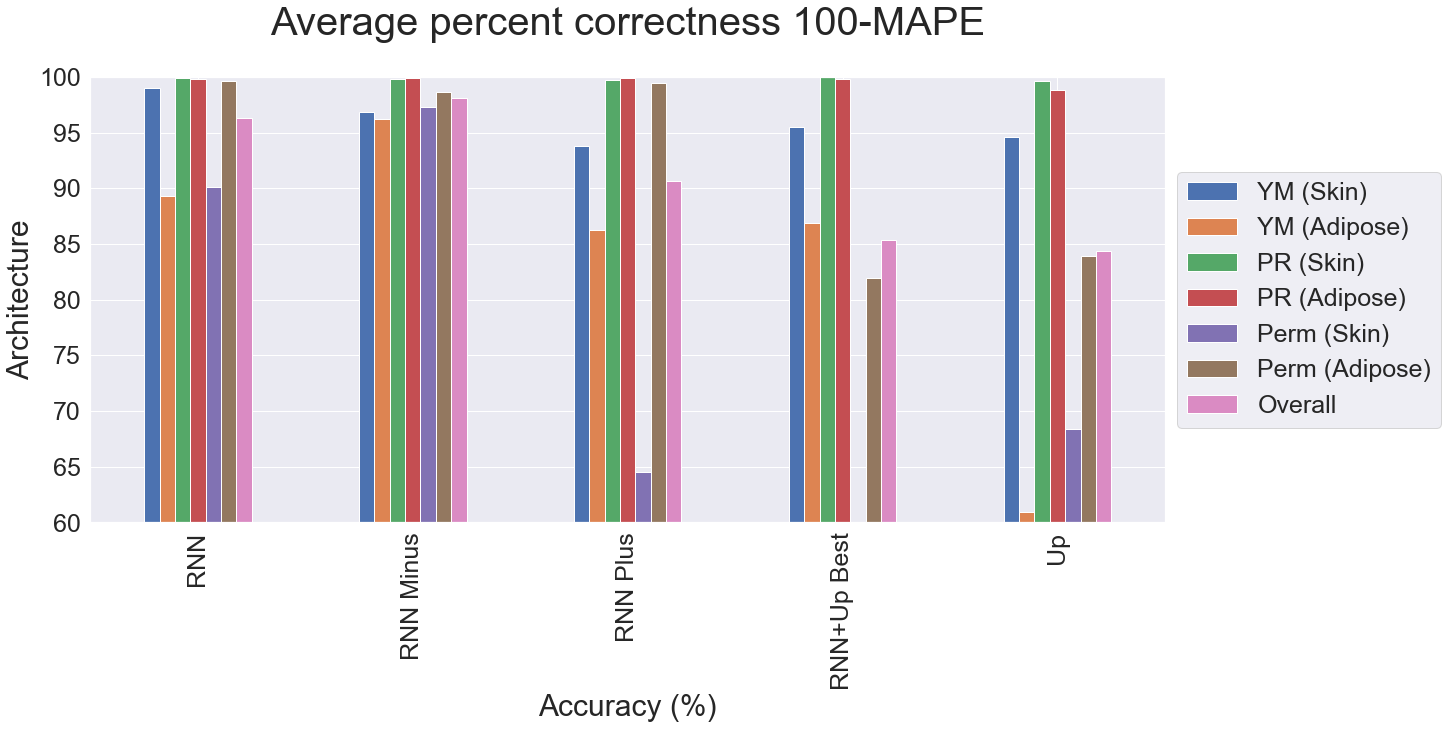

In [401]:
plotParameterBars(df)

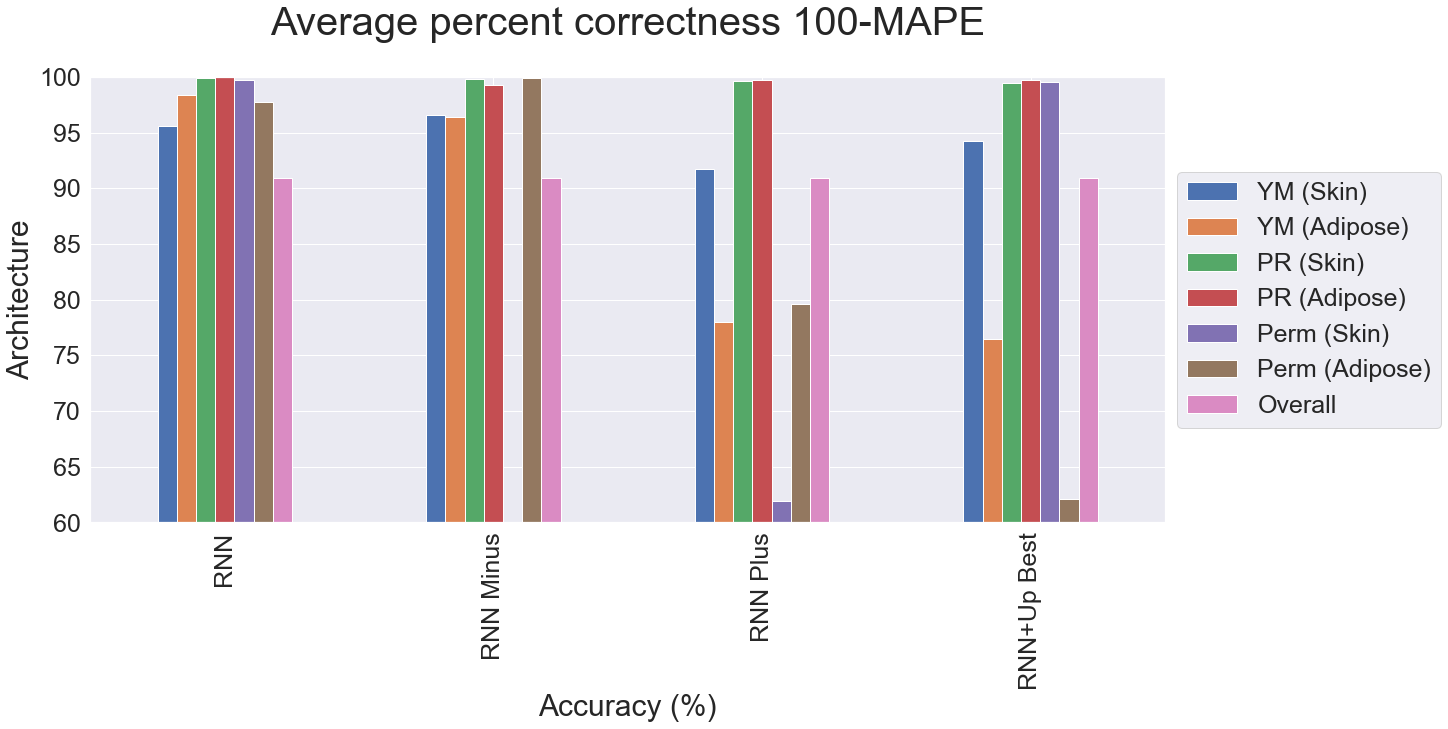

In [393]:
plotParameterBars(df)

In [5]:
class testCNN(nn.Module):
    def __init__(self):
        super(testCNN, self).__init__()
        # Probe 1
        self.x1_conv1 = nn.Conv1d(in_channels=1, out_channels=128, kernel_size=5, stride=1, padding=1)
        self.x1_bn1 = nn.BatchNorm1d(128)
        self.x1_pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        
        self.x1_conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.x1_bn2 = nn.BatchNorm1d(256)
        self.x1_pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.x1_conv3 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.x1_bn3 = nn.BatchNorm1d(512)
        self.x1_pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.rnn = nn.RNN(1, 128, batch_first=True)
        
        self.fc1 = nn.Linear(983040, 512)
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(p=0.5)
        
        self.fc3 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(p=0.5)
        
        self.fc4 = nn.Linear(128, 64)
        self.dropout4 = nn.Dropout(p=0.5)
        
        self.fc5 = nn.Linear(64, 6)
        
    def forward(self, x):
        # x1 = probe 1, x2 = probe 2
        batch_size = x.shape[0]
        x, x2 = x[:, 0, :].reshape(batch_size, 1, -1), x[:, 1, :].reshape(batch_size, 1, -1)
        x = self.x1_pool1(self.x1_bn1(torch.relu(self.x1_conv1(x))))
        x = self.x1_pool2(self.x1_bn2(torch.relu(self.x1_conv2(x))))
        x = self.x1_pool3(self.x1_bn3(torch.relu(self.x1_conv3(x))))
        
        """x2 = self.x2_pool1(self.x2_bn1(torch.relu(self.x2_conv1(x2))))
                           
        x2 = self.x2_pool2(self.x2_bn2(torch.relu(self.x2_conv2(x2))))
        x2 = self.x2_pool3(self.x2_bn3(torch.relu(self.x2_conv3(x2))))
        
        
        x1 = x1.view(batch_size, -1)
        x2 = x2.view(batch_size, -1)

        x = torch.stack((x1, x2))"""
        print(x.shape)
        x = x.reshape(batch_size, -1, 1)
        
        h0 = torch.zeros(1, batch_size, 128).to(x.device)
        x, _ = self.rnn(x, h0)
        
        x = x.reshape(batch_size, -1)
        
        x = torch.relu(self.dropout1(self.fc1(x)))
        x = torch.relu(self.dropout2(self.fc2(x)))
        x = torch.relu(self.dropout3(self.fc3(x)))
        x = torch.relu(self.dropout4(self.fc4(x)))
        x = self.fc5(x)
        x = x.reshape(batch_size, 6)
        #print(x.shape)
        return x

In [6]:
rnn = testCNN()

In [7]:
rnn_losses, rnn_val_losses, = train(train_loader, rnn, val_loader=test_loader, LR=0.0001, epochs=500)

Using: cuda:0


Epoch 1/500:   0%|                                                                           | 0/56 [00:00<?, ?batch/s]

torch.Size([32, 512, 15])


Epoch 1/500:   0%|                                                                           | 0/56 [00:02<?, ?batch/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.88 GiB (GPU 0; 11.00 GiB total capacity; 9.39 GiB already allocated; 0 bytes free; 9.56 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [10]:
DEVICE = 'cpu'